# Deep Convolutional GAN

In [1]:
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import LeakyReLU, BatchNormalization, Dropout, Input, RandomFlip
from keras.initializers import RandomNormal
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils import image_dataset_from_directory
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
np.random.seed(10)

save_path = "saved_models/"

noise_dim = 100

default_batch_size = 1
default_steps_per_epoch = 70
default_epochs = 10

img_rows, img_cols = 256, 256
channels = 1

optimizer = Adam(0.0002, 0.5)

In [3]:
def show_generated_images(noise, generator):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def load_images(directory):
    image_tf_dataset = image_dataset_from_directory(directory = directory, 
                                                    color_mode = 'grayscale', 
                                                    batch_size = None,
                                                    labels = None,
                                                    image_size = (img_rows, img_cols), 
                                                    crop_to_aspect_ratio = True)
    
    image_np_array = []
    for image in image_tf_dataset:
        image = tf.reshape(image, shape = [img_rows, img_cols, channels])
        image = image.astype(float) / 255
        image_np_array.append(image.numpy())
        
    image_np_array = np.asarray(image_np_array)
    return image_np_array

hms = load_images('split_heightmaps')

Found 37692 files belonging to 1 classes.


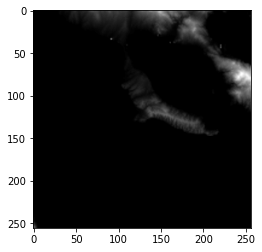

In [5]:
plt.imshow(hms[0], cmap='gray')

In [6]:
def create_generator():
    generator = Sequential()
    
    # Starting size
    d = 4
    generator.add(Dense(d*d*256, kernel_initializer = RandomNormal(0, 0.02), input_dim = noise_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same', 
                                  kernel_initializer = RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(channels, (2, 2), padding = 'same', activation = 'tanh', 
                         kernel_initializer = RandomNormal(0, 0.02)))
    
    generator.compile(loss = binary_crossentropy, optimizer = optimizer)
    return generator

In [7]:
def create_fcn_generator():
    generator = Sequential()
    
    generator.add(Dense(img_rows*img_cols, kernel_initializer = RandomNormal(0, 0.02), input_dim = noise_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((img_rows, img_cols, channels)))
    
    generator.add(Conv2D(64, (4, 4), strides = 1, padding = 'same'))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(64, (4, 4), strides = 1, padding = 'same'))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(64, (4, 4), strides = 1, padding = 'same'))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(64, (4, 4), strides = 1, padding = 'same'))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(channels, (2, 2), padding = 'same', activation = 'tanh'))
    
    generator.compile(loss = binary_crossentropy, optimizer = optimizer)
    return generator

In [8]:
def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Input(shape=(img_cols, img_rows, channels)))
    discriminator.add(RandomFlip('horizontal_and_vertical'))
    discriminator.add(Conv2D(64, (3, 3), padding = 'same', kernel_initializer = RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides = 2, padding = 'same', kernel_initializer = RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides = 2, padding = 'same', kernel_initializer = RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides = 2, padding = 'same', kernel_initializer = RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides = 2, padding = 'same', kernel_initializer = RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation = 'sigmoid', input_shape = (img_cols, img_rows, channels)))
    
    discriminator.compile(loss = binary_crossentropy, optimizer = optimizer)
    return discriminator

In [9]:
def create_gan():
    generator = create_fcn_generator()
    discriminator = create_discriminator()

    discriminator.trainable = False

    gan_input = Input(shape=(noise_dim,))
    fake_image = generator(gan_input)

    gan_output = discriminator(fake_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss = binary_crossentropy, optimizer = optimizer)
    
    return generator, discriminator, gan

In [10]:
def train_gan(generator, discriminator, gan, images, epochs, batch_size, steps_per_epoch = None):
    if steps_per_epoch == None:
        steps_per_epoch = math.floor(images.shape[0] / batch_size)
    
    discriminator_labels = np.zeros(2 * batch_size)
    discriminator_labels[:batch_size] = 0.9
    generator_labels = np.ones(batch_size)
    
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size = (batch_size, noise_dim))
            
            fake_image = generator.predict(noise)
            real_image = images[np.random.randint(0, images.shape[0], size=batch_size)]
            #ral_image = images[np.random.randint(0, images.shape[0])]
            combined_images = np.concatenate((real_image, fake_image))

            discriminator_loss = discriminator.train_on_batch(combined_images, discriminator_labels)
            generator_loss = gan.train_on_batch(noise, generator_labels)

        print(f'Epoch: {epoch} \t Discriminator Loss: {discriminator_loss} \t\t Generator Loss: {generator_loss}')
        
    return generator, discriminator, gan

In [11]:
generator1, discriminator1, gan1 = train_gan(*create_gan(), hms, epochs = 10, batch_size = 16)

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 12ms/step
Epoch: 0 	 Discriminator Loss: 0.6865495443344116 		 Generator Loss: 0.7955909967422485


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Epoch: 1 	 Discriminator Loss: 0.6885775327682495 		 Generator Loss: 0.7930054664611816


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Epoch: 2 	 Discriminator Loss: 0.6971292495727539 		 Generator Loss: 0.7704907059669495


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Epoch: 3 	 Discriminator Loss: 0.6830437183380127 		 Generator Loss: 0.8068666458129883


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step
Epoch: 4 	 Discriminator Loss: 0.6864458322525024 		 Generator Loss: 0.8019405603408813


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 19ms/step
Epoch: 5 	 Discriminator Loss: 0.6841800212860107 		 Generator Loss: 0.7935845255851746


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 6 	 Discriminator Loss: 0.6895650625228882 		 Generator Loss: 0.8054643869400024


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step
Epoch: 7 	 Discriminator Loss: 0.6838583946228027 		 Generator Loss: 0.8420416116714478


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step
Epoch: 8 	 Discriminator Loss: 0.684958815574646 		 Generator Loss: 0.7867947816848755


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Epoch: 9 	 Discriminator Loss: 0.6905157566070557 		 Generator Loss: 0.8010573387145996


1/1 [==============================] - 0s 53ms/step


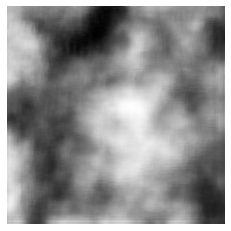

In [12]:
image = generator1.predict(np.random.normal(0, 1, size=(1, noise_dim)))
image = image.reshape((img_rows, img_cols))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
generator1.save("fcngan_generator2_256x256_e1_bs16.h5")

In [ ]:
generator1, discriminator1, gan1 = train_gan(generator1, discriminator1, gan1, hms, epochs = 10, batch_size = 16)

1/1 [==============================] - 0s 16ms/step
Epoch: 0 	 Discriminator Loss: 0.6996442675590515 		 Generator Loss: 0.7918193340301514
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


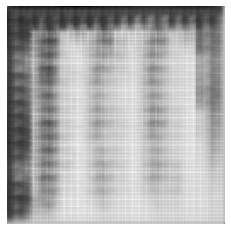

In [183]:
image = generator1.predict(np.random.normal(0, 1, size=(1, noise_dim)))
image = image.reshape((img_rows, img_cols))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()